In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Analyse des expériences rr_20210420

Pour rappel, les paramètres testés dans cet expériences sont: <br>
    parameters = { <br>
   "k_retriever": [1,5,20,50,100],<br>
   "k_title_retriever" : [10], # must be present, but only used when retriever_type == title_bm25<br>
   "k_reader_per_candidate": [5,10,20],<br>
   "k_reader_total": [5,10,20], <br>
   "retriever_type": ["bm25"], # Can be bm25, sbert, dpr, title or title_bm25 <br>
   "squad_dataset": ["./data/evaluation-datasets/full_spf_squad.json"], <br>
   "filter_level": [None], <br>
   "preprocessing": [True], <br>
   "boosting" : [1], #default to 1 <br>
   "split_by": ["word"], # Can be "word", "sentence", or "passage" <br>
   "split_length": [1000], <br>
   "experiment_name": ["dev"] <br>
} 

In [64]:
runs = pd.read_csv("runs.csv")

Nombre d'expériences :

In [54]:
len(runs)

45

Séléction des expé ayant une réponse:

In [13]:
runs = runs.loc[(runs['reader_topk_f1_has_answer'].isna()==False) & (runs['reader_topk_accuracy_has_answer'].isna()==False)]

In [32]:
#gestion du changement de notation
#runs['k_display'] = runs['k_display'].fillna(0)
#runs['k_reader'] = runs['k_reader'].fillna(0)
#runs['k_reader_total'] = runs['k_reader_total'].fillna(0)
#runs['k_reader_per_candidate'] = runs['k_reader_per_candidate'].fillna(0)

In [33]:
#runs['k_reader_per_candidate'] = runs['k_reader_per_candidate'] + runs['k_reader']
#runs['k_reader_total'] = runs['k_reader_total'] + runs['k_display']

Nombre d'expériences ayant une réponse : 

In [37]:
len(runs)

45

## Analyse de l'influence de k_retriever, k_reader_total et k_reader_per_candidate sur  top k accuracy

In [65]:
k_reader_total_tested = [5,10,20]

###   k_reader_total = 5

In [66]:
runs_5 = runs[runs['k_reader_total']==k_reader_total_tested[0]]

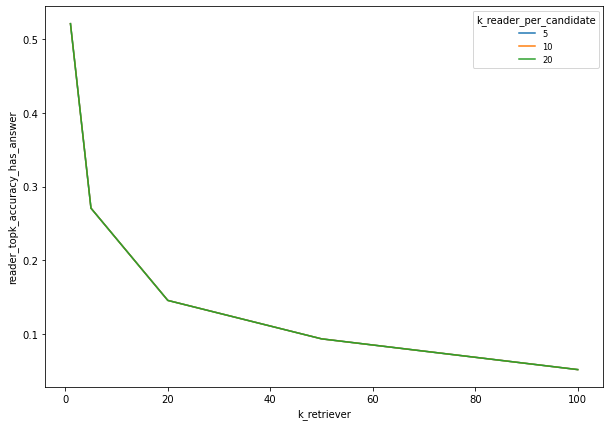

In [67]:
fig, ax = plt.subplots(figsize=(10,7))
runs_5.set_index('k_retriever', inplace=True)
runs_5.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

### k_reader_total = 10

In [68]:
runs_10 = runs[runs['k_reader_total']==k_reader_total_tested[1]]

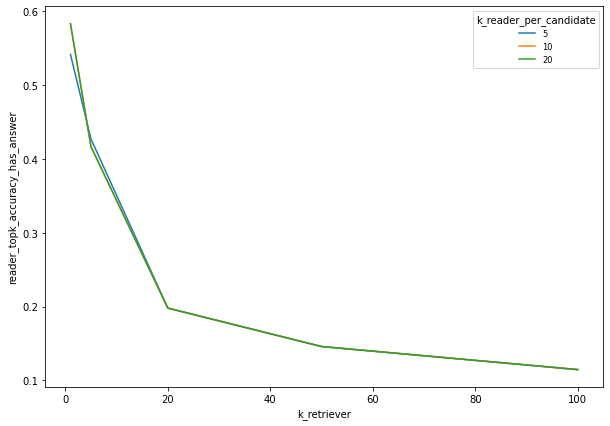

In [69]:
fig, ax = plt.subplots(figsize=(10,7))
runs_10.set_index('k_retriever', inplace=True)
runs_10.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

### k_reader_total = 20

In [70]:
runs_20 = runs[runs['k_reader_total']==k_reader_total_tested[2]]

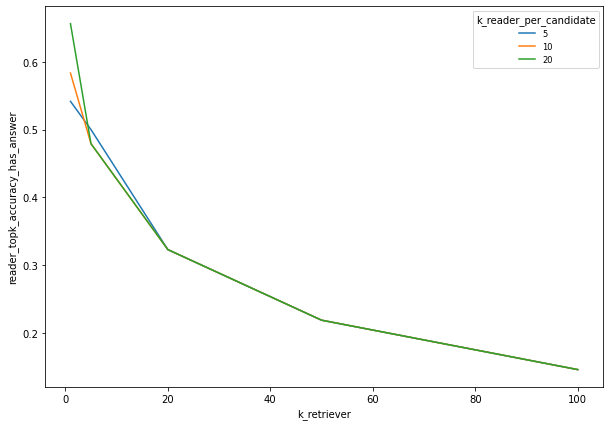

In [71]:
fig, ax = plt.subplots(figsize=(10,7))
runs_20.set_index('k_retriever', inplace=True)
runs_20.groupby(['k_reader_per_candidate'])['reader_topk_accuracy_has_answer'].plot(legend=True,ax=ax)
ax.set_ylabel('reader_topk_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

## Influence sur top1_accuracy

### k_reader_total = 5

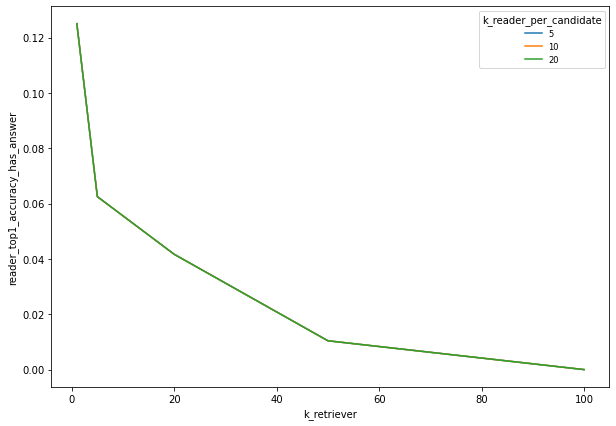

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
runs_5.set_index('k_retriever', inplace=True)
runs_5.groupby('k_reader_per_candidate')['reader_top1_accuracy_has_answer'].plot(legend=True)
ax.set_ylabel('reader_top1_accuracy_has_answer')
legend = plt.legend(title="k_reader_per_candidate",loc=1, fontsize='small')

Dans la suite du notebook, nous fixons `k_reader_total` = `5`

## Analyse de l'influence des paramètres sur time_per_label

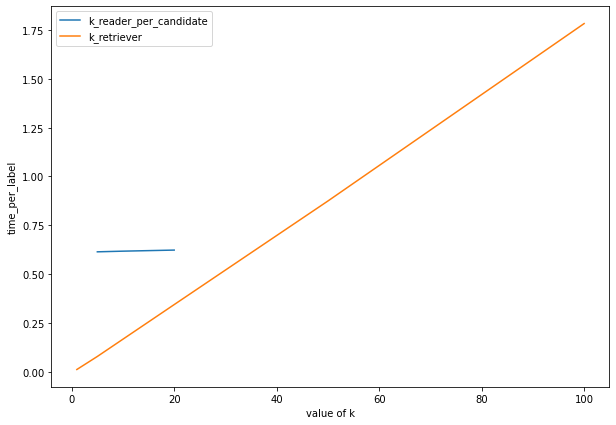

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
runs_5.groupby(by=['k_reader_per_candidate']).mean()["time_per_label"].plot()
runs_5.groupby(by=['k_retriever']).mean()["time_per_label"].plot()
plt.legend(['k_reader_per_candidate', 'k_retriever'], loc='upper left')
ax.set(xlabel='value of k', ylabel='time_per_label')
plt.show()